#### Imports

This is notebook run on <ins>Google Colab</ins>. Import the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import json
import itertools

import re
!pip install Unidecode
import unidecode

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer

tok = WordPunctTokenizer() 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 5.8 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#### Installing Kaggle and Downloading Sentiment analysis for financial news dataset

The code `!pip install kaggle` will install the Kaggle API. To run the this cell you will need to provide the Kaggle user and password in json format in the same directory of this notebook. Follow the tutorial available in the Further Reading section at the end of Chapter 6 to generate the Kaggle credentials. 
The code `!mkdir ~/.kaggle` will create a directory called `.kaggle` in the user's home directory, `!cp kaggle.json ~/.kaggle/` copy the `kaggle.json` file to the `.kaggle` directory and `!chmod 600 ~/.kaggle/kaggle.json` sets the permissions of the `kaggle.json` file to read-only. 

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download the dataset located at `ankurzing/sentiment-analysis-for-financial-news`. Unzip the dataset downloaded into the notebook's working directory. 

In [ ]:
!kaggle datasets download ankurzing/sentiment-analysis-for-financial-news
!unzip sentiment-analysis-for-financial-news.zip

#### Building the dataset

Read the raw CSV file `Cryptocurrency Curated News Event Database From GDELT` from the given URL. We select the columns 'news' and 'final_manual_labelling' from the file and rename it to 'title' and 'sentiment' respectively.

In [ ]:
url= 'https://media.githubusercontent.com/media/manoelgadi/CryptoGDelt2022/master/Sentiment/CryptoLin_IE_v2.csv'
columns=['news','final_manual_labelling']
cryptogdelt = pd.read_csv(url, usecols=columns)
cryptogdelt.rename (columns={"news": "title", "final_manual_labelling": "sentiment"}, inplace= True)
cryptogdelt.head()

,title,sentiment
0,"Ripple announces stock buyback, nabs $15 billi...",1
1,IMF directors urge El Salvador to remove Bitco...,-1
2,Dragonfly Capital is raising $500 million for ...,1
3,Rick and Morty co-creator collaborates with Pa...,0
4,How fintech SPACs lost their shine,0


From the Kaggle dataset downloaded in the previous section we only select the `Sentences_AllAgree.txt` file. 

In [ ]:
df_trad= pd.read_csv ("/content/FinancialPhraseBank/Sentences_AllAgree.txt", sep='@', encoding = "ISO-8859-1",
                 header=None, names=["title", "sentiment"])
df_trad.shape

(2264, 2)

#### Combining Dataframes
Combine the dataframes `df_trad` and `cryptogdelt` into a single dataframe and reset the index. Later we normalize the sentiments according to the following criteria: 

*   0: Negative
*   1: Positive
*   2: Neutral

And shuffle the rows of the dataset.

In [ ]:
df= pd.concat([df_trad, cryptogdelt], ignore_index=True) 

In [ ]:
def identification (sentiment):
  if sentiment =='positive':
    return 1
  elif sentiment ==1:
    return 1
  elif sentiment =='negative':
      return 0
  elif sentiment ==-1:
      return 0
  elif sentiment =='neutral':
      return 2
  elif sentiment ==0:
      return 2
      
df['sentiment'] = df['sentiment'].apply(identification)

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,title,sentiment
0,Net interest income increased by 4.5 % to EUR ...,1
1,Return on investment was 16.6 % compared to 15...,1
2,The Oxyview Pulse Oximeter is a common device ...,2
3,Feel EUROMANIA - the hottest football promotio...,2
4,Goldman Sachs joins $28 million Series A for b...,1


#### Description of the dataset

*   Distribution of each class
*   Number of rows

Create a bar chart to visualize the data grouping the data by the `sentiment` column. 

<Axes: xlabel='sentiment'>

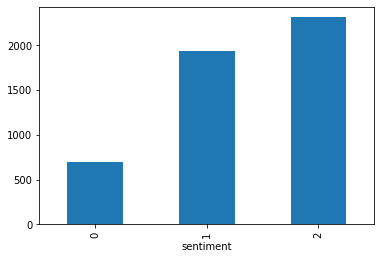

In [ ]:
df.groupby(['sentiment']).size().plot (kind = 'bar') 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      4947 non-null   object
 1   sentiment  4947 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 77.4+ KB


#### Preprocessing

Get the part of speech (POS) tag for a given word. It will then map the POS tag to the first character that the lemmatize() function accepts. The function will return the POS tag as a dictionary.

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Use NLTK and the unidecode library to clean the text. Lowercase the text, remove links, remove stop words, remove words with length less than 4, lemmatize the words, and remove certain words from the text. 

In [ ]:
pat1 = r'https[^ ]+' # links
pat2 = r'www.[^ ]+' # more links
pat = r'|'.join((pat1, pat2))
filter=['crypto', 'bitcoin', 'ethereum', 'company','blockchain', 'say', 'million'] #words to be filtered
def get_clean_text(text):
    text = str (text)
    text = text.lower() # lowercase
    text = unidecode.unidecode(text) 
    text = re.sub(pat, ' ', text)    
    text = [w for w in tok.tokenize(text) if w not in stop_words] # remove stop_words
    text = [w for w in text if len(w)>3] # remove words with len <4
    text = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text] 
    text = [w for w in text if w not in filter]
    text = (' '.join(text)).strip()
    return text

df['title'] = [get_clean_text(t) for t in df['title']]


#### Plot frequency of words

Tokenize the titles and display a frequency distribution of the words with a barplot. 

In [ ]:
titles_tokenized = []
for i in range(df.shape[0]):
    headline = df.iloc[i].title
    headline = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(headline) 
    titles_tokenized.append(headline)
titles_tokenized = list(itertools.chain(*titles_tokenized))
freq_titles_tokenized = nltk.FreqDist(titles_tokenized)
df_tok_titles = pd.DataFrame(list(freq_titles_tokenized.items()), columns = ["Word","Frequency"])
df_tok_titles.sort_values('Frequency',ascending=False, inplace = True, ignore_index=True)

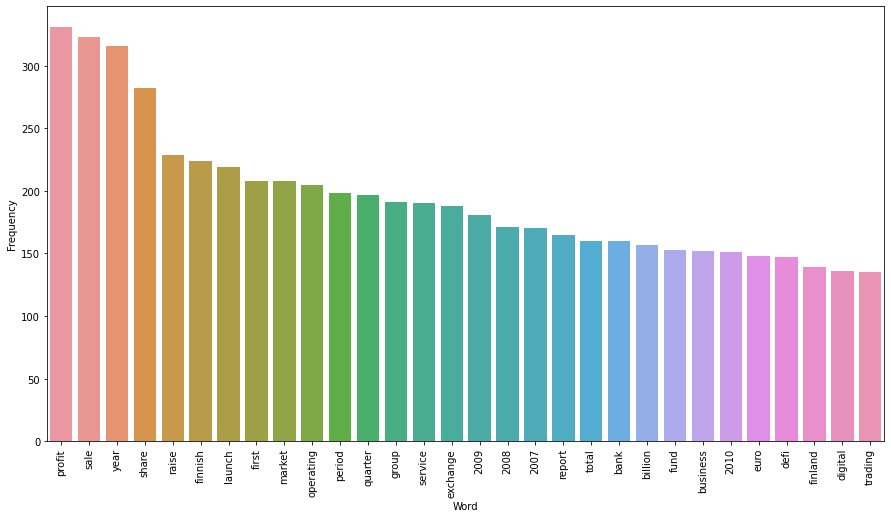

In [ ]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_tok_titles.iloc[:30].Word, y = df_tok_titles.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.savefig('figure72.png')
plt.show()

#### Final cleaning and save as .csv for training

In [ ]:
df.head()

In [ ]:
df['title']=df['title'].str.strip().replace('',np.nan)
df=df.loc[df['title'] != '?????, ?????']
df.dropna (inplace= True)

In [ ]:
df.to_csv ("preprocessed.csv", index=False)